# Часть 1. Проверка гипотезы в Python и составление аналитической записки

## Проверка гипотезы о том, что петербуржцы больше времени проводят с книгами в приложении

- Автор: Заплатин Артем Александрович (aazaplatin@yandex.ru)
- Дата: 30.05.2025

## Цели и задачи проекта

**Цель:**

- Проверить гипотезу о том, что пользователи из Санкт-Петербурга в среднем больше читаю и прослушивают книги в приложении, чем пользователи из Москвы.

**Задачи:**

- Выгрузить данные и проверить наличие дубликатов;
- Сравнить размеры групп, их статистики и распределения;
- Выбрать тип теста и уровень статистической значимости;
- Провести тест и посчитать pvalue. Интерпретировать полученный результат;
- Составить аналитическую записку, написать возможные причины полученного результата.


## Описание данных

Предобработанная таблица `yandex_knigi_data`:

- `city` - город пользователя. Может принимать одно из двух значений: Москва или Санкт-Петербург;
- `puid` - id пользователя;
- `hours` - суммарная длительность чтения или прослушивания в часах;

## Содержимое проекта

1. [Загрузка данных и знакомство с ними](#1-загрузка-данных-и-знакомство-с-ними)
2. [Проверка гипотезы в Python](#2-проверка-гипотезы-в-python)
3. [Аналитическая записка](#3-аналитическая-записка)

---

## 1. Загрузка данных и знакомство с ними

Загружаем данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания).

In [1]:
# Импортируем библиотеку pandas
import pandas as pd
# Импортируем библиотеку numpy
import numpy as np

# Импортируем библиотеку matplotlib для визуализации линейного графика
import matplotlib.pyplot as plt
# Импортируем библиотеку seaborn для визуализации распределения и построения KDE
import seaborn as sns

# Импортируем ttest_ind из scipy.stats для проведения стат.теста с помощью т-теста
import scipy.stats as stats
from scipy.stats import mannwhitneyu

# Импортируем proportions_ztest из statsmodels.stats.proportion 
# для проведения стат.теста с помощью z-теста 
from statsmodels.stats.proportion import proportions_ztest

from statsmodels.stats.power import NormalIndPower

Датасет yandex_knigi_data был получен с помощью SQL запроса

```
    select
        usage_geo_id_name as city,
        puid,
        sum(hours) as hours
    from bookmate.audition
    join bookmate.geo using (usage_geo_id) 
    where usage_geo_id_name in ('Москва', 'Санкт-Петербург')
    group by usage_geo_id_name, puid

```

In [ ]:
# Сохраняем датасет yandex_knigi_data.csv в датафрейм book_df
# Датасет скрыт, т.к. является интеллектуальной собственностью Я.Практикум
books_df = pd.read_csv('secret_key', index_col='Unnamed: 0')

display(books_df.head(5))

books_df.info()

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


<class 'pandas.core.frame.DataFrame'>
Index: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 274.5+ KB


<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Наблюдение:**

- Пропуски отсутствуют;
- Типы данных соответствуют содержанию.

Необходимо проверить на дубликаты колонку `puid`

</div>

In [3]:
# Проверяем кол-во дубликатов
sum_duplicated = books_df.duplicated(subset='puid').sum()
print(f'Кол-во дубликатов по колонке puid: {sum_duplicated} шт.')

Кол-во дубликатов по колонке puid: 244 шт.


In [4]:
# Удаляем дубликаты, предварительно отсортировав таблицу по возрастанию 
# Таким образом избежим удаления дубликатов только в одной группе
books_df = books_df.sort_values(by=['puid', 'hours']).drop_duplicates(subset=['puid'], keep='last', ignore_index=True) 

# Проверяем кол-во дубликатов
sum_duplicated = books_df.duplicated(subset='puid').sum()
print(f'Кол-во дубликатов по колонке puid: {sum_duplicated} шт.')

Кол-во дубликатов по колонке puid: 0 шт.


<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Наблюдение:**

- Дубликаты удалены более-менее равномерно.

Далее проверим кол-во пользователей в каждой группе (выборке) и распределение часов - для выбора теста. 

Посчитаем статистики для каждой группы пользователей.

</div>

In [5]:
# Группируем клиентов по городу
city_group = books_df.groupby('city')['puid'].nunique()
city_group

city
Москва             6099
Санкт-Петербург    2441
Name: puid, dtype: int64

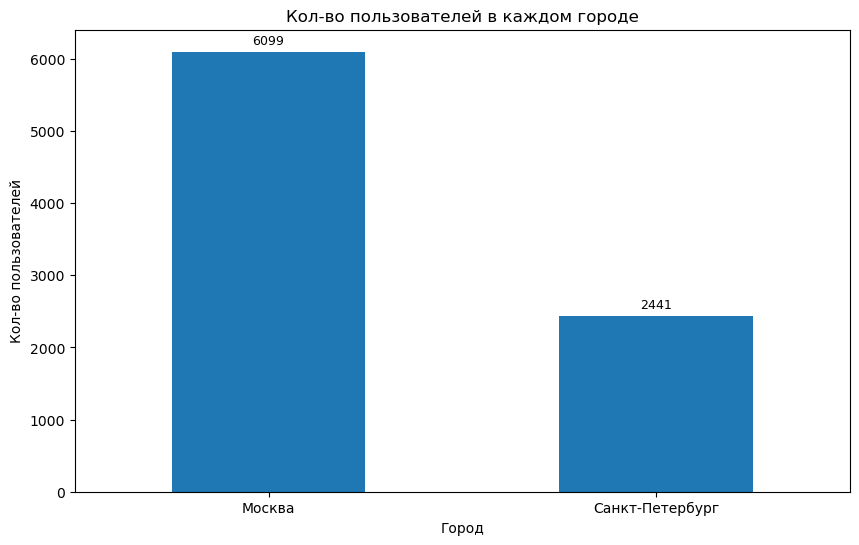

In [6]:
# Создаем столбчатую диаграмму для отображения кол-ва клиентов в каждом городе
plt.figure(figsize=(10, 6))
city_group.plot.bar()

plt.xlabel('Город')
plt.ylabel('Кол-во пользователей')
plt.xticks(rotation=0)
plt.title('Кол-во пользователей в каждом городе')

for idx, value in enumerate(city_group):
    plt.text(idx, value + max(city_group)*0.01, str(value), ha='center', va='bottom', fontsize=9)
    
plt.show()

In [7]:
# Выводим статистическое описание
books_df.groupby('city')['hours'].describe().T

city,Москва,Санкт-Петербург
count,6099.000000,2441.000000
mean,11.075176,12.028376
std,37.229705,40.521834
min,0.000022,0.000025
25%,0.058889,0.075278
50%,0.930357,1.025801
75%,6.025852,6.880545
max,857.209373,978.764775


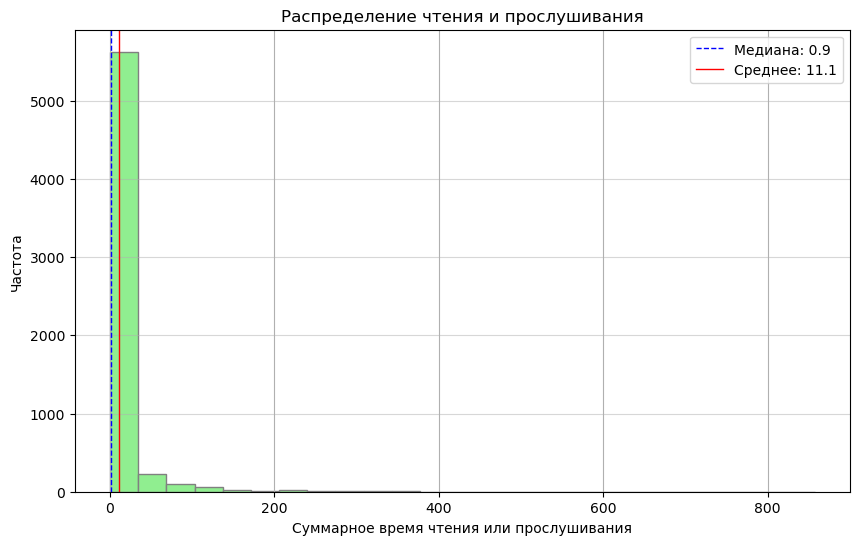

In [8]:
# Строим гистограмму по распределению чтения и прослушивания книг в Москве

plt.figure(figsize=(10, 6))
books_df[books_df['city'] == 'Москва']['hours'].dropna().hist(bins=25, 
                                 color='lightgreen', 
                                 edgecolor='grey')

# Считаем медиану и среднее
median_msc = books_df[books_df['city'] == 'Москва']['hours'].median()
mean_msc = books_df[books_df['city'] == 'Москва']['hours'].mean()

# Добавляем линий медианы и среднего
plt.axvline(median_msc, color='blue', linestyle='--', linewidth=1, label=f'Медиана: {median_msc:.1f}')
plt.axvline(mean_msc, color='red', linestyle='-', linewidth=1, label=f'Среднее: {mean_msc:.1f}')

plt.title('Распределение чтения и прослушивания')
plt.xlabel('Суммарное время чтения или прослушивания')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.show()

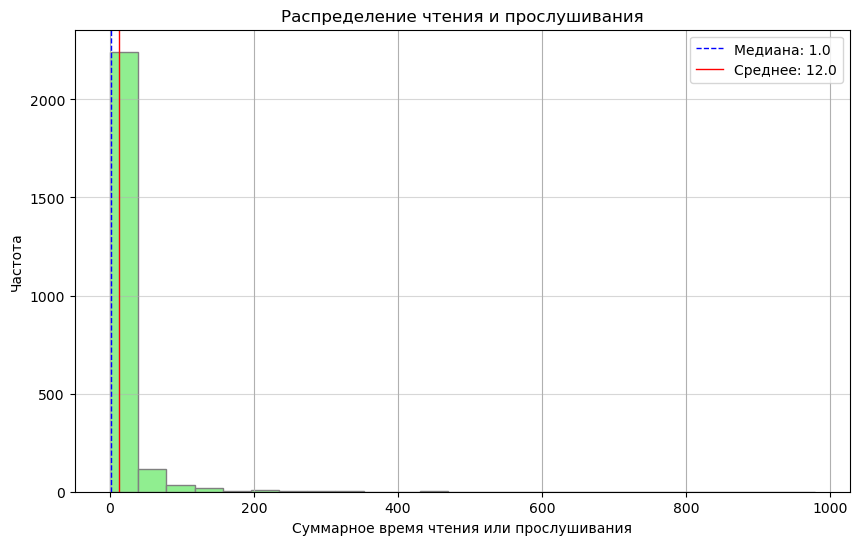

In [9]:
# Строим гистограмму по распределению в Санкт-Петербурге
plt.figure(figsize=(10, 6))
books_df[books_df['city'] == 'Санкт-Петербург']['hours'].dropna().hist(bins=25, 
                                 color='lightgreen', 
                                 edgecolor='grey')

# Считаем медиану и среднее
median_spb = books_df[books_df['city'] == 'Санкт-Петербург']['hours'].median()
mean_spb = books_df[books_df['city'] == 'Санкт-Петербург']['hours'].mean()

# Добавляем линий медианы и среднего
plt.axvline(median_spb, color='blue', linestyle='--', linewidth=1, label=f'Медиана: {median_spb:.1f}')
plt.axvline(mean_spb, color='red', linestyle='-', linewidth=1, label=f'Среднее: {mean_spb:.1f}')

plt.title('Распределение чтения и прослушивания')
plt.xlabel('Суммарное время чтения или прослушивания')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.show()

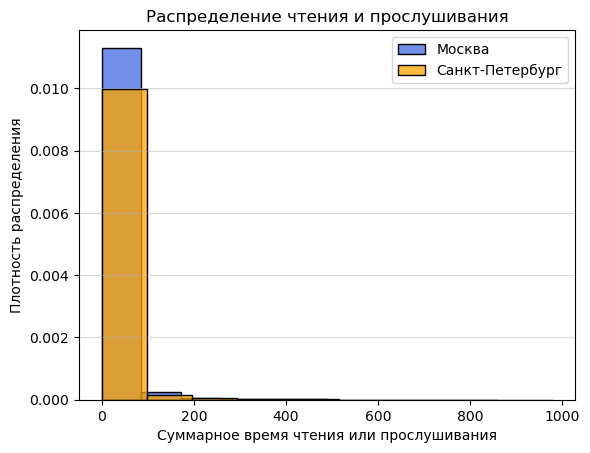

In [10]:
# Визуализируем распределение 
sns.histplot(books_df[books_df['city'] == 'Москва']['hours'], 
             bins=10, 
             label='Москва', 
             color='royalblue',
             stat='density',
             common_norm=False
             )
sns.histplot(books_df[books_df['city'] == 'Санкт-Петербург']['hours'], 
             bins=10,
             label='Санкт-Петербург', 
             color='orange',
             stat='density',
             common_norm=False
             )
plt.title('Распределение чтения и прослушивания')
plt.xlabel('Суммарное время чтения или прослушивания')
plt.ylabel('Плотность распределения')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.show()

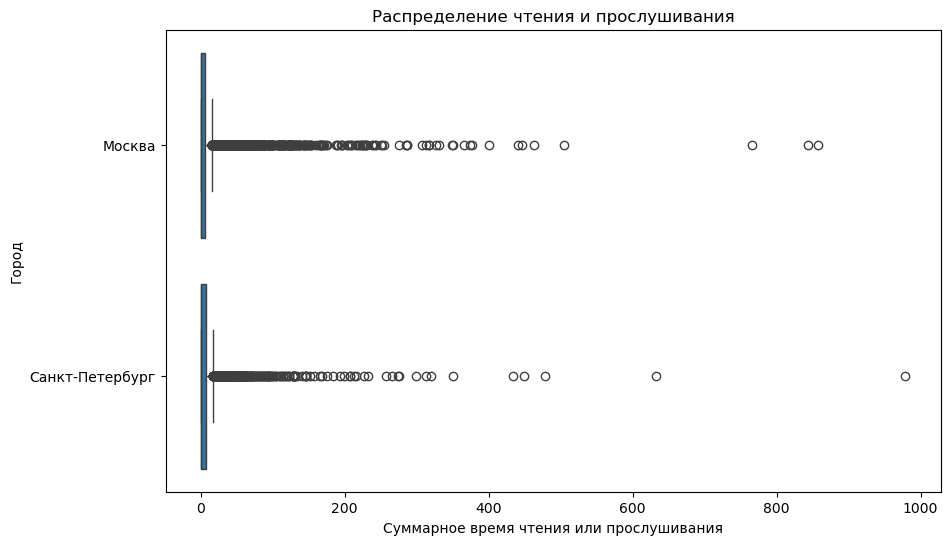

In [11]:
# Строим диаграмму размаха
plt.figure(figsize=(10, 6))
sns.boxplot(data=books_df, x='hours', y='city')
plt.title('Распределение чтения и прослушивания')
plt.suptitle('')
plt.xlabel('Суммарное время чтения или прослушивания')
plt.ylabel('Город')
plt.show()

<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Наблюдение:**

- Кол-во выборок в группе неравное, при этом стоит отметить, что для t-теста или Манна-Уитни необязательно соблюдать равенство в выборках;
- Распределение больше похоже на экспоненциальное, чем на нормальное;
- Статистики выборок варьируются, а также имеются аномальные значения (далее Москва и Санкт-Петербург соответственно): 
    - Оценочные стандартные отклонения у выборок 37 и 40 часов;
    - Минимальные значения - 0 часов;
    - Максимальные - 857 и 978 часов;
    - Среднее 11 и 12 часов, медиана около 1 часа;

Удаление выбросов не поспособствует изменению распределения на нормальное и приведет к потери большого кол-ва информации.

Так как исследуемая метрика выражена в абсолютном значении, то необходимо выбирать между тестом Манна-Уитни и t-тестом. Сначала опишем наши выборки и распределения:

- Выборки имеют экспоненциальное распределение;
- Неравные дисперсии;
- Большое кол-во выбросов, которые нельзя удалить/изменить.

Так как оба теста не требуют нормального распределения в следствии центральной предельной теоремы, а также не чувствительны к дисперсии (с поправкой Уэлча в t-тесте), то фактором для выбора теста будут являться выбросы - поэтому применим тест Манна-Уитни.

</div>

## 2. Проверка гипотезы в Python

Гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве (μ СПб ≤ μ Мск).

- Альтернативная гипотеза H₁: Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо (μ СПб > μ Мск).

<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Наблюдение:**

Для начала определим тип теста и необходимые данные для его проведения:

- Тип теста: на предыдущем этапе определили, что используем теста Манна-Уитни;
- Тест стандартный, не требующий крайней внимательности к ошибкам, поэтому уровень стат.значимость - 5%;
- Санкт-Петербург сравниваем с Москвой, поэтому используем правостороннюю гипотезу.

</div>

In [12]:
# Уровень статистической значимости
alpha = 0.05 

# Применяем тест Манна — Уитни
test_result_pvalue = mannwhitneyu(
    books_df[books_df['city'] == 'Санкт-Петербург']['hours'], 
    books_df[books_df['city'] == 'Москва']['hours'], 
    alternative='greater'
).pvalue

if test_result_pvalue > alpha:
    print(f'pvalue={test_result_pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={test_result_pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.06159915490740047 > 0.05
Нулевая гипотеза находит подтверждение!


<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Наблюдение:**

- pvalue оказался выше уровня статистической значимости, что говорит о том, что с текущими выборками мы не смогли отвергнуть нулевую гипотезу, т.е не смогли отвергнуть гипотезу, что в Санкт-Петербурге в среднем читают не больше, чем в Москве.

</div>

## 3. Аналитическая записка

<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Наблюдение:**

1. По результатам анализа выборок и распределений бьл выбран тест Манна-Уитни;
2. Уровень стат. значимости был выбран 0.05 , так как в условиях теста не требуется детальная внимательность к ошибкам;
3. В результат проведения стат. теста получили значение p-value = 0.06, что выше уровня alpha;
4. Так как p-value больше alpha, то не смогли отвергнуть нулевую гипотезу.

Причины полученного результата:
- Распределение данных достаточно похоже;
- В двух группах большой разброс данных, что снижает чувствительность теста;
- Стоит рассмотреть более конкретные выборки по клиентам: по полу, по возрасту и т.д.

</div>

----

# Часть 2. Анализ результатов A/B-тестирования

#### Техническое задание проведённого теста:

Параметры теста:
- название теста: `interface_eu_test`;
- группы: `А` (контрольная), `B` (новый интерфейс).

Что нужно:
- загрузить данные теста;
- проверить корректность его проведения;
- проанализировать полученные результаты.

Данные

1. `ab_test_participants` — таблица участников тестов.

Структура файла:
- `user_id` — идентификатор пользователя;
- `group` — группа пользователя;
- `ab_test` — название теста;
- `device` — устройство, с которого происходила регистрация.

2. `ab_test_events` — архив с одним csv-файлом, в котором собраны события 2020 года;

Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии.

Дополнительная информация по столбцу `details`

Числовые значения:
- `registration` (регистрация) — стоимость привлечения клиента;
- `purchase` (покупка) — стоимость покупки.

---

## 1. Цель и задачи исследования.

**Цель:**

- Оценить влияние новой версии сайта интернет-магазина BitMotion Kit на конверсию пользователей — определить, приводит ли обновлённый интерфейс к увеличению числа совершённых покупок.

**Задачи:**

- Загрузить и проверить целостность данных по участникам и событиям A/B-теста;
- Оценить корректность проведения эксперимента (распределение по группам, отсутствие пересечений, соответствие ТЗ);
- Проанализировать пользовательскую активность в обеих группах;
- Рассчитать конверсию и сравнить её между контрольной и тестовой группами;
- Провести статистическую проверку гипотезы о различии конверсий;
- Сформулировать выводы и рекомендации по результатам теста.

## 2. Загрузка данных, оценка их целостность.


In [ ]:
# Загружаем данные
# Датасеты скрыты, т.к. являются интеллектуальной собственностью Я.Практикума
participants = pd.read_csv('secret_key')
events = pd.read_csv('secret_key', parse_dates=['event_dt'], low_memory=False)

In [14]:
# Проверяем загруженные данные
display(participants.shape[0])
display(participants.head())
participants.info()

14525

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [15]:
# Проверяем уникальные значения в колонке ab_test
participants['ab_test'].unique()

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

In [16]:
# Проверяем пересечения клиентов в тестовой группе и в стороннем тесте
intersection_participants = list(set(participants[(participants['group']=='B') 
                                                    & (participants['ab_test']=='recommender_system_test')]['user_id']) 
                                & set(participants[(participants['group']=='B') 
                                                    & (participants['ab_test']=='interface_eu_test')]['user_id']))

if len(intersection_participants) == 0:
    print('Пересечений пользователей в группах нет')
else:
    print(f'Кол-во пересекающихся пользователей: {len(intersection_participants)}')

Кол-во пересекающихся пользователей: 116


In [17]:
# Проверяем загруженные данные
display(events.shape[0])
display(events.head())
events.info()

787286

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [18]:
# Проверяем события на дубликаты
sum_duplicated_events = events.duplicated().sum()

print(f'Кол-во дубликатов в датафрейме events: {sum_duplicated_events} шт.')

Кол-во дубликатов в датафрейме events: 36318 шт.


In [19]:
# Удаляем дубликаты
events = events.drop_duplicates()

# Проверяем события на дубликаты
sum_duplicated_events = events.duplicated().sum()

print(f'Кол-во дубликатов в датафрейме events: {sum_duplicated_events} шт.')

Кол-во дубликатов в датафрейме events: 0 шт.


## 3. Оцениваем корректность проведения теста по таблице `ab_test_participants` :

   3\.1 Выделяем пользователей, участвующих в тесте, и проверяем следующее:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [20]:
# Проверяем соответствие ТЗ
ab_test_participants = participants[participants['ab_test'] == 'interface_eu_test'].copy()

# Удаляем пользователей из группы B, которые попали в несколько тестов
ab_test_participants = ab_test_participants[~ab_test_participants['user_id'].isin(intersection_participants)].copy()

print(f'Кол-во пользователей в тесте interface_eu_test: {ab_test_participants.shape[0]}')

print('Группы в эксперименте:', ab_test_participants['group'].unique())

Кол-во пользователей в тесте interface_eu_test: 10734
Группы в эксперименте: ['B' 'A']


Разница пользователей в группе составляет 0.59%


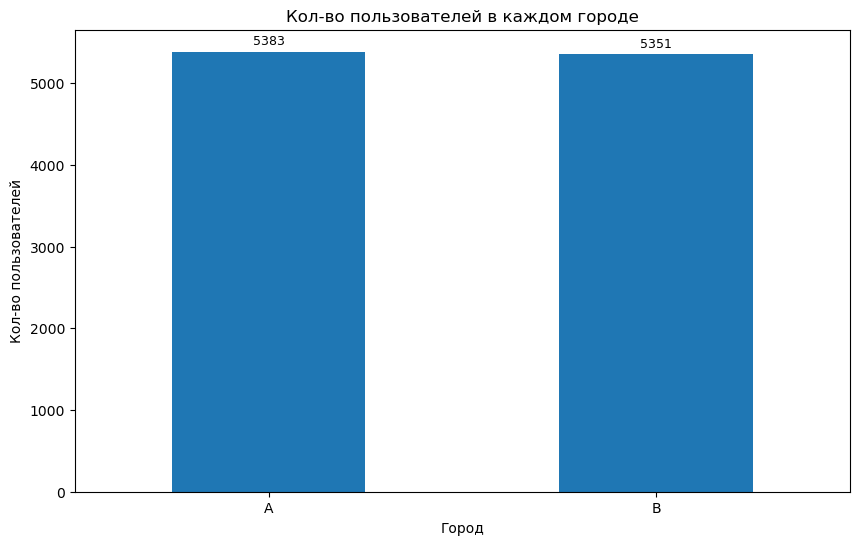

In [21]:
# Проверяем равномерность распределения пользователей по группам
users_group = ab_test_participants.groupby('group')['user_id'].nunique()

diff_cnt_user = round(100 - users_group['B'] / users_group['A'] * 100, 2)
print(f'Разница пользователей в группе составляет {diff_cnt_user}%')

# Создаем столбчатую диаграмму для отображения кол-ва клиентов в каждом городе
plt.figure(figsize=(10, 6))
users_group.plot.bar()

plt.xlabel('Город')
plt.ylabel('Кол-во пользователей')
plt.xticks(rotation=0)
plt.title('Кол-во пользователей в каждом городе')

for idx, value in enumerate(users_group):
    plt.text(idx, value + max(users_group)*0.01, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [22]:
# Проверяем кол-во дубликатов
cnt_duplicated = ab_test_participants.duplicated(subset='user_id').sum()
print(f'Кол-во дубликатов по колонке user_id: {cnt_duplicated} шт.')

Кол-во дубликатов по колонке user_id: 0 шт.


In [23]:
intersection = len(list(set(ab_test_participants[ab_test_participants['group']=='A']['user_id']) 
                    & set(ab_test_participants[ab_test_participants['group']=='B']['user_id'])))

if intersection == 0:
    print('Пересечений пользователей в группах нет')
else:
    print(f'Кол-во пересекающихся пользователей: {intersection}')

Пересечений пользователей в группах нет


<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Наблюдение:**

- Данные соответствуют ТЗ;
- Группы распределены равномерно с небольшой погрешностью в 0.6%;
- Дубликатов и пересечений пользователей нет.

</div>

3\.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- оставляем только события, связанные с участвующими в изучаемом тесте пользователями;

In [24]:
test_user_ids = ab_test_participants['user_id'].unique()
ab_test_events = events[events['user_id'].isin(test_user_ids)].copy()

print(f'Всего событий в тесте: {ab_test_events.shape[0]}')

ab_test_events.head()

Всего событий в тесте: 72935


,user_id,event_dt,event_name,details
64672,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0
64946,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8
66585,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32
67873,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48
67930,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0


- определяем горизонт анализа: рассчитываем время (лайфтайм) совершения события пользователем после регистрации и оставляем только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [25]:
# Получим дату регистрации для каждого пользователя
registrations = (
    ab_test_events[ab_test_events['event_name'] == 'registration']
    .groupby('user_id', as_index=False)['event_dt']
    .min()).copy()
registrations = registrations.rename(columns={'event_dt': 'registration_dt'})

In [26]:
# Объединим дф с событиями и дф с регистрацией
ab_test_events = ab_test_events.merge(registrations, on='user_id', how='left')

# Считаем разницу между датой события и датой регистрации
ab_test_events['days_from_registration'] = (ab_test_events['event_dt'] - ab_test_events['registration_dt']).dt.days

In [27]:
# Фильтруем события, совершённые в течение первых 7 дней после регистр.
ab_test_events_7d = ab_test_events[(ab_test_events['days_from_registration'] < 7)].reset_index(drop=True).copy()
# ab_test_events_7d = ab_test_events[(ab_test_events['event_name'] != 'registration')].reset_index(drop=True)


print(f'Событий в течение первых 7 дней после регистрации: {ab_test_events_7d.shape[0]}')
ab_test_events_7d.sort_values(by=['user_id', 'event_dt'], ascending=True).head()

Событий в течение первых 7 дней после регистрации: 62934


,user_id,event_dt,event_name,details,registration_dt,days_from_registration
541,0002CE61FF2C4011,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0
542,0002CE61FF2C4011,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0
543,0002CE61FF2C4011,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0
545,0002CE61FF2C4011,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0
4890,0002CE61FF2C4011,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,1


Оцениаем достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- Ожидаемый прирост конверсии - 3%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [28]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый показатель конверсии
mde = 0.03 # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = abs(2 *  (np.arcsin(np.sqrt(p)) - np.arcsin(np.sqrt(p + mde)))),
    power = power,
    alpha = alpha,
    ratio = 1,
    alternative='larger'
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 2963


<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Наблюдение:**

- При оценке достаточности выборки выявлено, что размер каждой группы должен составить 2963
- Кол-во пользователей в группах более 5000

Следовательно, можно сделать вывод, что пользователей в группах достаточно для проведения и корректной оценки результатов.

</div>

- рассчитываем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [29]:
# Объединяем датафреймы 
merge_df = ab_test_participants.merge(ab_test_events_7d, how='left', on='user_id')

In [30]:
# Создаем сводную таблицу
pivot_table_merge_df = merge_df[merge_df['event_name'].isin(['registration', 'purchase'])].pivot_table(index='group',
                                                                    columns='event_name',
                                                                    values='user_id',
                                                                    aggfunc='nunique')

pivot_table_merge_df['conversion'] = round(pivot_table_merge_df['purchase'] / pivot_table_merge_df['registration'], 3)
pivot_table_merge_df

event_name,purchase,registration,conversion
group,,,
A,1480,5383,0.275
B,1579,5351,0.295


In [31]:
# Считаем процентную разницу конверсии групп
diff_conversion = round(100 * (abs(pivot_table_merge_df.loc['A']['conversion'] 
                                   - pivot_table_merge_df.loc['B']['conversion']) 
                                   / pivot_table_merge_df.loc['A']['conversion']), 2)
print(f'Разница пользователей в группе составляет {diff_conversion}%')

Разница пользователей в группе составляет 7.27%


- Предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Наблюдение:**

- Кол-во событий, которые совершили клиенты, попавшие в тест, составило 72935;
- Из них 62934 событий совершено в течение первых 7 дней после регистрации;
- Для проведения теста рассчитали необходимый размер выборки для каждой группы - 2963;
- **Не достигнут ожидаемый прирост конверсии в 3%. Изменение в конверсии составило 2%, а процентная разница между группами составила 7%**

Необходимо провести статистический тест, чтобы доказать, что на изменение метрики связано с новым дизайном, а не случайным изменением показателя.

</div>

## 4. Проведем оценку результатов A/B-тестирования:

- Проверяем изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

Так как метрика у нас долевая, то для проведения статистического теста будем использовать z-тест.

Для начала проверим, выполняется ли предпосылка о достаточном кол-ве данных для проведения теста.

</div>

In [32]:
# Считаем размер выборок в тестовых группах
n_a = pivot_table_merge_df.loc['A']['registration']
n_b = pivot_table_merge_df.loc['B']['registration']

# Считаем кол-во покупок
m_a = pivot_table_merge_df.loc['A']['purchase']
m_b = pivot_table_merge_df.loc['B']['purchase']

# Считаем конверсию 
p_a = m_a / n_a
p_b = m_b / n_b

# Проверяем предпосылку о достаточности данных
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется')

Предпосылка о достаточном количестве данных выполняется


<div style="background-color:rgb(202, 246, 252); padding: 10px; border-radius: 5px; color: black; border-color: black">

Сформулируем гипотезы для проведения стат теста:

- H0: Конверсия в контрольной группе (`B`) не больше, чем в тестовой группе (`A`) (CR B ≤ CR A)
- H1: Конверсия в контрольной группе (`B`) выше, чем в тестовой группе (`A`) (CR B > CR A)

</div>

In [33]:
# Проводим односторонний статистический тест с помощью z-теста
stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)
if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.010393282955333764 < 0.05
Нулевая гипотеза не находит подтверждения!


- Описываем выводы по проведённой оценке результатов A/B-тестирования:

<div style="background-color:rgb(205, 247, 214); padding: 10px; border-radius: 5px; color: black; border-color: black">

**Вывод:**

В рамках проекта был проведен A/B-тест по обновлению сайта.

При проведении анализа выполнено следующее:

- Проверили, что данные соответствуют техническому заданию;
- Проверили корректность проведения теста - группы распределены равномерно;
- оценили достаточность выборки - данных достаточно для проведения теста;
- Выявили изменение конверсии в группах - в тестовой группе конверсия оказалась на 2% выше, чем в контрольной группе (т.е. процентная разница составила 7%);
- Изменение конверсии проверено статистическим тестом с помощью z-теста - мы получили значение p-value = 0.01, что меньше уровня статистической значимости, а значит, что с текущими выборками и результатами по ним не смогли подтвердить нулевую гипотезу, т.е. НЕ смогли доказать, что в контрольной группе конверсия не больше, чем в тестовой.

Конверсия увеличилась (что также подтверждено статистически), при этом ожидаемый прирост конверсии не был достигнут. Поэтому рекомендации следующие:
- Обсудить, достаточно ли экономически выявленного прироста конверсии в 2% - если да - можно раскатывать упрощенную версию сайта;
- Если не достаточно - рассмотреть вариант проведения повторного теста с изменением параметров (более точные выборки, сокращение mde).

</div>